# Описание проекта

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения.
Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
После этого исследуйте результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.
Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, вы можете быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.
В случае общей аналитики и A/A/B-эксперимента работайте с одними и теми же данными. В реальных проектах всегда идут эксперименты. Аналитики исследуют качество работы приложения по общим данным, не учитывая принадлежность пользователей к экспериментам.

Описание данных
Каждая запись в логе — это действие пользователя, или событие.

    EventName — название события;
    DeviceIDHash — уникальный идентификатор пользователя;
    EventTimestamp — время события;
    ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Шаг 1. Откройте файл с данными и изучите общую информацию
Изучим файл /datasets/logs_exp.csv. Изучим данные с помощью метода info(). Выведем первые строки таблицы методом head(), чтобы познакомиться с данными.

In [1]:
import pandas as pd
from datetime import date

from scipy import stats as st
import numpy as np
import math as mth

import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px

from statsmodels.stats.proportion import proportions_ztest
import warnings

warnings.filterwarnings('ignore')

In [2]:
exp = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
exp.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [3]:
exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
EventName         244126 non-null object
DeviceIDHash      244126 non-null int64
EventTimestamp    244126 non-null int64
ExpId             244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


В датасете 4 колонки с записями о действиях пользователя: EventName типа object, DeviceIDHash типа int64, EventTimestamp типа int64 и ExpId типа int64. Всего 244126 строк в каждом столбце, значит, пропусков нет.            

## Шаг 2. Подготовьте данные

### Замените названия столбцов на удобные для вас;

Текущие названия столбцов для меня удобны, поэому оставим их как есть.

### Проверьте пропуски и типы данных. Откорректируйте, если нужно;

Пробежимся по данным и проверим их на корректность. Для этого воспользуемся методом describe() для численных строк и методами .unique()/.value_counts() для категориальных данных.


In [4]:
exp['EventName'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

In [5]:
exp['EventName'].value_counts() 

MainScreenAppear           119205
OffersScreenAppear          46825
CartScreenAppear            42731
PaymentScreenSuccessful     34313
Tutorial                     1052
Name: EventName, dtype: int64

Всего 5 возможных вариантов событий - 'MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'. Больше всего в выгрузке событий типа 'MainScreenAppear' (119205) - переходов на главный экран. Примерно в два раза меньше событий типа OffersScreenAppear и CartScreenAppear.

In [6]:
exp['DeviceIDHash'].value_counts()

6304868067479728361    2308
197027893265565660     2003
4623191541214045580    1771
6932517045703054087    1448
1754140665440434215    1222
                       ... 
7724520246123323531       1
2760145394827990211       1
2086627244641656064       1
8164821368561674670       1
1083512226259476085       1
Name: DeviceIDHash, Length: 7551, dtype: int64

Всего в датасете 7551 уникальных идетификаторов пользователя.

In [7]:
exp['EventTimestamp'].describe()

count    2.441260e+05
mean     1.564914e+09
std      1.771343e+05
min      1.564030e+09
25%      1.564757e+09
50%      1.564919e+09
75%      1.565075e+09
max      1.565213e+09
Name: EventTimestamp, dtype: float64

Рассматриваемый период времени - от 25 июля 2019 до 8 августа 2019 года, то есть, 14 дней.

In [8]:
exp['ExpId'].unique()

array([246, 248, 247])

In [9]:
exp['ExpId'].value_counts()

248    85747
246    80304
247    78075
Name: ExpId, dtype: int64

В логах находится информация о трех экспериментах, разбивка по группам практически равная.

In [10]:
#проверим на дубликаты
exp[exp.duplicated()]

,EventName,DeviceIDHash,EventTimestamp,ExpId
453,MainScreenAppear,5613408041324010552,1564474784,248
2350,CartScreenAppear,1694940645335807244,1564609899,248
3573,MainScreenAppear,434103746454591587,1564628377,248
4076,MainScreenAppear,3761373764179762633,1564631266,247
4803,MainScreenAppear,2835328739789306622,1564634641,248
...,...,...,...,...
242329,MainScreenAppear,8870358373313968633,1565206004,247
242332,PaymentScreenSuccessful,4718002964983105693,1565206005,247
242360,PaymentScreenSuccessful,2382591782303281935,1565206049,246
242362,CartScreenAppear,2382591782303281935,1565206049,246


Видим дубликаты. Удалим их.

In [11]:
exp.drop_duplicates(inplace = True)

In [12]:
exp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 4 columns):
EventName         243713 non-null object
DeviceIDHash      243713 non-null int64
EventTimestamp    243713 non-null int64
ExpId             243713 non-null int64
dtypes: int64(3), object(1)
memory usage: 9.3+ MB


In [13]:
#посмотрим на нулевые значения
pd.DataFrame(round((exp.isna().mean()*100),2)).style.background_gradient('coolwarm')

,0
EventName,0
DeviceIDHash,0
EventTimestamp,0
ExpId,0


Нулевых значений нет.

###  Добавьте столбец даты и времени, а также отдельный столбец дат;

In [14]:
#добавим колонку с датой и временем
exp['EventDateTime'] = pd.to_datetime(exp.EventTimestamp, unit='s')

In [15]:
#добавим колонку с датой
exp['EventDate'] = exp['EventDateTime'].dt.date

В датасет добавлены столбцы EventDateTime и EventDate.

## Шаг 3. Изучите и проверьте данные

### Сколько всего событий в логе?

In [16]:
exp['EventName'].value_counts() 

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: EventName, dtype: int64

В логе 5 событий.

### Сколько всего пользователей в логе?

In [17]:
before = exp.DeviceIDHash.nunique()
print(f'Число уникальных пользователей: {exp.DeviceIDHash.nunique():,}')

Число уникальных пользователей: 7,551


Всего в датасете 7551 уникальных идетификаторов пользователя.

### Сколько в среднем событий приходится на пользователя?

In [18]:
exp['DeviceIDHash'].value_counts().describe()

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: DeviceIDHash, dtype: float64

В среднем на пользователя приходится 32 события, медианное значение - 20. Видим большое максимальное число событий - 2308, возможно, именно такие числа и внесли различие между средним и медианой.

### Данными за какой период вы располагаете?

Найдите максимальную и минимальную дату. Постройте гистограмму по дате и времени. Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определите, с какого момента данные полные и отбросьте более старые. Данными за какой период времени вы располагаете на самом деле?

In [19]:
exp['EventDate'].max()

datetime.date(2019, 8, 7)

Максимальная дата - 7 августа 2019 года.

In [20]:
exp['EventDate'].min()

datetime.date(2019, 7, 25)

Минимальная дата - 25 июля 2019 года.

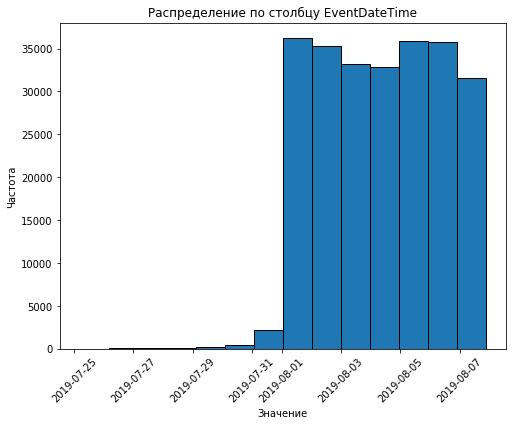

In [21]:
plt.figure(figsize =(8, 6))
exp['EventDateTime'].hist(
                bins=14, edgecolor='black'
                )
plt.title('Распределение по столбцу EventDateTime')
plt.xlabel('Значение')
plt.xticks(rotation=45)
plt.ylabel('Частота')
plt.grid()
plt.show()

Мало данных за период с 25.07.2019 по 31.07.2019. Большое число событий за период с 01.08.2019 по 07.08.2019, порядка 35 тысяч в день.
Если подумать о причине, можно предположить, что если это моб. приложение, то в в них сложно провести AB-тест без апдейта через стор, и дальше мы можем либо сразу открыть обновление на всех пользователей, либо на процент. Скорее всего, в данном случае обновление включалось на процент, постепенно.

Если говорить о достоверности анализа данных за 7-8 дней, то, в общем, это зависит от дизайна теста. В нашем случае это приложение по доставке еды, поэтому человеку не нужно находиться в приложении месяц, чтобы сделать заказ, и, по сути, для того, чтобы совершить целевое действие, ему достаточно 1 дня.
Поэтому для данного теста 7 дней будет достаточно.

In [22]:
exp['EventDate'].value_counts().reset_index().sort_values('index')

,index,EventDate
13,2019-07-25,9
12,2019-07-26,31
11,2019-07-27,55
10,2019-07-28,105
9,2019-07-29,184
8,2019-07-30,412
7,2019-07-31,2030
0,2019-08-01,36141
3,2019-08-02,35554
4,2019-08-03,33282


Продолжительность теста, по сути, не влияет на достоверность теста.
Достоверность теста зависит от числа пользователей в каждой группе. Чем больше пользователей, чем больше разница в поведении, и тем с большей вероятностью результаты теста будут достоверными. 

In [23]:
#Отбросим события, произошедшие раньше 1 августа
exp = exp[exp.EventDate > date(2019, 7, 31)].copy()

### Много ли событий и пользователей вы потеряли, отбросив старые данные?

In [24]:
exp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240887 entries, 2828 to 244125
Data columns (total 6 columns):
EventName         240887 non-null object
DeviceIDHash      240887 non-null int64
EventTimestamp    240887 non-null int64
ExpId             240887 non-null int64
EventDateTime     240887 non-null datetime64[ns]
EventDate         240887 non-null object
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 12.9+ MB


Потеряли порядка 3 тысяч записей. Среди общего числа записей это немного, порядка 1%.

In [25]:
after = exp.DeviceIDHash.nunique()
print(f'Число потерянных пользователей: {before - after}')

Число потерянных пользователей: 17


Потеряли 17 пользователей. Это очень немного.

### Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.

In [26]:
exp['ExpId'].value_counts()

248    84563
246    79302
247    77022
Name: ExpId, dtype: int64

Пользователи из всех трех экспериментальных групп у нас есть.

### Вывод

Изучены и проверены данные из логов.

В логе всего 5 событий: MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful и Tutorial.

Всего в датасете 7551 уникальных идетификаторов пользователя.

В среднем на пользователя приходится 32 события, медианное значение - 20. Максимальное число событий - 2308, возможно, именно такие числа и внесли различие между средним и медианой.

Максимальная дата - 7 августа 2019 года. Минимальная дата - 25 июля 2019 года.

Мало данных за период с 25.07.2019 по 31.07.2019. Большое число событий за период с 01.08.2019 по 07.08.2019, порядка 35 тысяч в день. Если подумать о причине, можно предположить, что если это моб. приложение, то в в них сложно провести AB-тест без апдейта через стор, и дальше мы можем либо сразу открыть обновление на всех пользователей, либо на процент. Скорее всего, в данном случае обновление включалось на процент, постепенно.

Если говорить о достоверности анализа данных за 7-8 дней, то, в общем, это зависит от дизайна теста. В нашем случае это приложение по доставке еды, поэтому человеку не нужно находиться в приложении месяц, чтобы сделать заказ, и, по сути, для того, чтобы совершить целевое действие, ему достаточно 1 дня. Поэтому для данного теста 7 дней будет достаточно.

Отбросив старые данные, потеряли порядка 3 тысяч записей. Среди общего числа записей это немного, порядка 1%. Потеряно 17 пользователей.

Пользователи из всех трех экспериментальных групп у нас есть.

## Шаг 4. Изучите воронку событий

### Посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте.

In [27]:
exp['EventName'].value_counts().reset_index().sort_values('EventName')

,index,EventName
4,Tutorial,1005
3,PaymentScreenSuccessful,33918
2,CartScreenAppear,42303
1,OffersScreenAppear,46333
0,MainScreenAppear,117328


В логах есть события Tutorial, PaymentScreenSuccessful, CartScreenAppear, OffersScreenAppear, MainScreenAppear. Чаще всего встречается событие с переходом на главный экран.

### Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.

In [28]:
exp.groupby('EventName')['DeviceIDHash'].nunique().sort_values()

EventName
Tutorial                    840
PaymentScreenSuccessful    3539
CartScreenAppear           3734
OffersScreenAppear         4593
MainScreenAppear           7419
Name: DeviceIDHash, dtype: int64

Видим количество пользователей, которые совершили то или иное действие. Чаще всего встречается событие MainScreenAppear - появление главного экрана(7419). Меньше всего встречается событие Tutorial (840).                  

Далее, чтобы расчитать долю, берем кол-во уникальных пользователей, совершивших событие, и делим его на общее число уникальных пользователей.

In [29]:
exp_aggr = exp.groupby('EventName')['DeviceIDHash'].nunique().sort_values()
exp_aggr

EventName
Tutorial                    840
PaymentScreenSuccessful    3539
CartScreenAppear           3734
OffersScreenAppear         4593
MainScreenAppear           7419
Name: DeviceIDHash, dtype: int64

In [30]:
exp_aggr = exp_aggr.to_frame().reset_index()

In [31]:
total = exp_aggr['DeviceIDHash'].sum()
total

20125

In [32]:
exp_aggr['share'] = (exp_aggr['DeviceIDHash'] / total).round(2) * 100
exp_aggr['share'] = exp_aggr['share'].map('{0:.2f}%'.format)
exp_aggr

,EventName,DeviceIDHash,share
0,Tutorial,840,4.00%
1,PaymentScreenSuccessful,3539,18.00%
2,CartScreenAppear,3734,19.00%
3,OffersScreenAppear,4593,23.00%
4,MainScreenAppear,7419,37.00%


Доли пользователей, которые хоть раз совершали событие, увеличиваются в том же порядке. Больше всего доля пользователей, перешедших на главный экран (0.37), далее идут пользователи, увидевшие оффер (0.23), после чего увидевшие корзину (0.19) и совершившие оплату (0.18). Доля прошедших туториал меньше всего - 0.04.

### Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.

Понятно, что порядок событий не явлется строгим, но логичтно предположить, что сначала пользователь видит основной экран (MainScreenAppear), затем экран с оффером (OffersScreenAppear), потом попадает в корзину (CartScreenAppear), потом экран успешной оплаты (PaymentScreenSuccessful). Туториал, наверное, есть перед всем этим, но в воронку его включать, я думаю, не стоит.

### По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.

Создадим список с событиями, которые будем включать в воронку, и отфильтруем наш датасет по ним.

In [33]:
funnel_events = [event for event in exp.EventName.unique() if 'Screen' in event]
funnel_events

['MainScreenAppear',
 'OffersScreenAppear',
 'CartScreenAppear',
 'PaymentScreenSuccessful']

In [34]:
#сделаем отдельный датафрем для воронки
exp_funnel = exp[exp.EventName.isin(funnel_events)]

In [35]:
exp_funnel.EventName.value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Name: EventName, dtype: int64

Посчитаем количество уникальных пользователей для каждого события.

In [36]:
exp_funnel = exp_funnel.groupby('EventName')['DeviceIDHash'].nunique().reset_index()
exp_funnel

,EventName,DeviceIDHash
0,CartScreenAppear,3734
1,MainScreenAppear,7419
2,OffersScreenAppear,4593
3,PaymentScreenSuccessful,3539


In [37]:
#отсортируем в порядке убывания
a = exp_funnel.sort_values(by='DeviceIDHash',ascending=False)
a

,EventName,DeviceIDHash
1,MainScreenAppear,7419
2,OffersScreenAppear,4593
0,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539


Посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем).

In [38]:
a['share'] = a['DeviceIDHash']/a['DeviceIDHash'].shift(1)
a['share'] = (a['share'] * 100).round(2).map('{0:.2f}%'.format)
a

,EventName,DeviceIDHash,share
1,MainScreenAppear,7419,nan%
2,OffersScreenAppear,4593,61.91%
0,CartScreenAppear,3734,81.30%
3,PaymentScreenSuccessful,3539,94.78%


Доли пользователей, которые проходят на следующий шаг воронки (от числа пользователей на предыдущем):
* 62% переходят на шаг от MainScreenAppear до OffersScreenAppear
* 81% переходят на шаг от OffersScreenAppear до CartScreenAppear
* 94% переходят на шаг  от CartScreenAppear до PaymentScreenSuccessful

### На каком шаге теряете больше всего пользователей?

Построим график воронки.

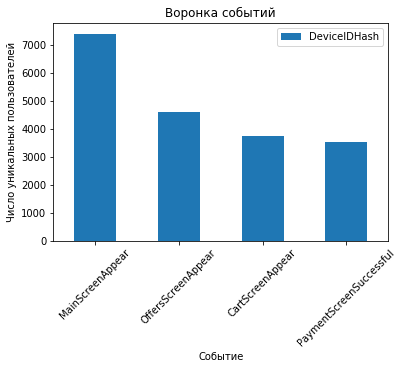

In [39]:
exp_funnel.sort_values('DeviceIDHash', ascending=False).plot(kind='bar', x='EventName')
plt.title('Воронка событий')
plt.xlabel('Событие')
plt.xticks(rotation=45)
plt.ylabel('Число уникальных пользователей')
plt.show()

Между первым (7419) и вторым шагом (4593) мы теряем больше всего пользователей.

### Какая доля пользователей доходит от первого события до оплаты?

Посмотрим на процентное различие между событими воронки.

In [40]:
exp_funnel.sort_values('DeviceIDHash', ascending=False)['DeviceIDHash'].pct_change()

1         NaN
2   -0.380914
0   -0.187024
3   -0.052223
Name: DeviceIDHash, dtype: float64

Получили доли, которые мы теряем на каждом шаге воронки:

38% терям на шаге от MainScreenAppear до OffersScreenAppear

19% теряем на шаге от OffersScreenAppear до CartScreenAppear

5% теряем на шаге от CartScreenAppear до PaymentScreenSuccessful

Проход по всем этапам воронки не является обязательным, так что работать нужно относительно общего числа клиентов в группах. Нам важно не то, как пользователи идут по воронке, а то, сколько пользователей доходит до каждого шага.

Вычислим, какой процент пользователей доходит от первого события до оплаты. Конверсия считается по формуле:
(Количество пользователей совершивших целевое действие/общее число пользователей)*100%

In [42]:
exp_funnel

,EventName,DeviceIDHash
0,CartScreenAppear,3734
1,MainScreenAppear,7419
2,OffersScreenAppear,4593
3,PaymentScreenSuccessful,3539


In [45]:
share = (exp_funnel.get_value(3,'DeviceIDHash') / exp_funnel.get_value(1,'DeviceIDHash')).round(2)
print('{:.0%} пользователей доходит от первого события до оплаты'.format(share))

48% пользователей доходит от первого события до оплаты


### Вывод

Изучены события в логах и то, как часто они встречаются. 
В логах есть события Tutorial, PaymentScreenSuccessful, CartScreenAppear, OffersScreenAppear, MainScreenAppear. Чаще всего встречается событие с переходом на главный экран.

Проверено, сколько пользователей совершали каждое из этих событий. Чаще всего встречается событие MainScreenAppear - появление главного экрана(7419). Меньше всего встречается событие Tutorial (840).

Чтобы расчитать долю пользователей, которые хоть раз совершали событие, мы взяли кол-во уникальных пользователей, совершивших событие, и разделили его на общее число уникальных пользователей. Доли пользователей, которые хоть раз совершали событие, увеличиваются в том же порядке. Больше всего доля пользователей, перешедших на главный экран (0.37), далее идут пользователи, увидевшие оффер (0.23), после чего увидевшие корзину (0.19) и совершившие оплату (0.18). Доля прошедших туториал меньше всего - 0.04.

Понятно, что порядок событий не явлется строгим, но логичтно предположить, что сначала пользователь видит основной экран (MainScreenAppear), затем экран с оффером (OffersScreenAppear), потом попадает в корзину (CartScreenAppear), потом экран успешной оплаты (PaymentScreenSuccessful). Туториал, наверное, есть перед всем этим, но в воронку его включать, я думаю, не стоит.

Создан список с событиями, которые будут включены в воронку, далее посчитано количество уникальных пользователей для каждого события.
Доли пользователей, которые проходят на следующий шаг воронки (от числа пользователей на предыдущем) следующие: 

    62% переходят на шаг от MainScreenAppear до OffersScreenAppear
    81% переходят на шаг от OffersScreenAppear до CartScreenAppear
    94% переходят на шаг от CartScreenAppear до PaymentScreenSuccessful


Построен график воронки. Между первым (7419) и вторым шагом (4593) мы теряем больше всего пользователей.

Изучено процентное различие между событими воронки. Получены доли, которые мы теряем на каждом шаге воронки:

    38% терям на шаге от MainScreenAppear до OffersScreenAppear
    19% теряем на шаге от OffersScreenAppear до CartScreenAppear
    5% теряем на шаге от CartScreenAppear до PaymentScreenSuccessful

При этом 48% пользователей доходит от первого события до оплаты.

## Шаг 5. Изучите результаты эксперимента

    
    
    
   
    

### Сколько пользователей в каждой экспериментальной группе?

In [46]:
exp.groupby('ExpId')['DeviceIDHash'].nunique()

ExpId
246    2484
247    2513
248    2537
Name: DeviceIDHash, dtype: int64

В каждой экспериментальной группе примерно одинаковое число участников - около 2.5 тысяч.

### Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.

В тесте у нас есть пользователи контрольных групп 246 и 247 и пользователи экспериментальной группы 248.

In [47]:
exp_246 = exp.query('ExpId == 246').groupby('ExpId')['DeviceIDHash'].nunique().reset_index()
exp_247 = exp.query('ExpId == 247').groupby('ExpId')['DeviceIDHash'].nunique().reset_index()

In [48]:
diff = 1 - exp_246.iloc[0]['DeviceIDHash'] / exp_247.iloc[0]['DeviceIDHash']
print('Разница между выборками 246 и 247 - {:.2%}'.format(diff))

Разница между выборками 246 и 247 - 1.15%


Между выборками 246 и 247 разница небольшая, ~1%, это приемлемо для контрольных групп.

### Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?

Посмотрим, сколько пользователей совершали каждое событие в каждой экспериментальной группе.

In [49]:
exp.pivot_table(index='EventName', columns='ExpId', values='DeviceIDHash', aggfunc='nunique')

ExpId,246,247,248
EventName,,,
CartScreenAppear,1266,1238,1230
MainScreenAppear,2450,2476,2493
OffersScreenAppear,1542,1520,1531
PaymentScreenSuccessful,1200,1158,1181
Tutorial,278,283,279


Самое популярное событие - MainScreenAppear. Тут большой разницы между количеством пользователей нет.
В 246 группе больше всего событий оплаты (PaymentScreenSuccessful).

Создадим функцию, считающую статистическую значимость между группами.
Датафрейм будем обрабатывать внутри функции, группы будем передавать в виде списка. 

Сформулируем гипотезы

Н0 - различия между экспериментальными группами, совершившими указанное событие, статистически не значимы

Н1 - различия между экспериментальными группами, совершившими указанное событие, статистически значимы

Пороговое значение alpha примем за 5%.

In [50]:
def ab_calc(df, group_ids, alpha):
    #найдем уникальных пользователей в каждой группе
    users = [df.query('ExpId == @group_id')['DeviceIDHash'].nunique() for group_id in group_ids]
    #перебираем все экспериментальные группы для каждого события, считаем количество пользователей и долю
    for event in df.EventName.unique():
        events = [df.query('ExpId == %d and EventName == "%s"' % (group_id, event))['DeviceIDHash'].nunique() for group_id in group_ids]
        # сравниваем кол-во уникальных юзеров на каждом шаге группы к кол-ву уникальных юзеров в этой группе всего
        p1 = events[0] / users[0] #считаем долю для 1 группы
        p2 = events[1] / users[1] #считаем долю для 2 группы
        
        p_combined = sum(events) / sum(users) 
        
        difference = p1 - p2 # разница в датасетах
        
        z_value = difference / mth.sqrt(
            p_combined * (1 - p_combined) * (1 / users[0] + 1 / users[1]) #считаем z-value, которая покажет, насколько она далека от среднего значения точки данных
        )
        
        distr = st.norm(0, 1) #распределение
        p_value = (1 - distr.cdf(abs(z_value))) * 2 #считаем p-value
        
        print(event)
        print(p1, p2)
        print('p-значение: ', p_value)
        #сравниваем p-value и alpha
        if p_value < alpha:
            print('Отвергаем нулевую гипотезу по событию %s: между долями есть значимая разница' % (event))
        else:
            print('Не получилось отвергнуть нулевую гипотезу по событию %s: нет оснований считать доли разными' % (event))
            
        print('-------------------------------')
        print(' ')

Сначала проводим A/A тестирование - это проверка всего эксперимента на валидность.

In [51]:
#посмотрим на события в 246 и 247 группах
ab_calc(exp, [246, 247], 0.05)

Tutorial
0.11191626409017713 0.11261440509351373
p-значение:  0.9376996189257114
Не получилось отвергнуть нулевую гипотезу по событию Tutorial: нет оснований считать доли разными
-------------------------------
 
MainScreenAppear
0.9863123993558777 0.9852765618782332
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу по событию MainScreenAppear: нет оснований считать доли разными
-------------------------------
 
OffersScreenAppear
0.6207729468599034 0.6048547552725826
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу по событию OffersScreenAppear: нет оснований считать доли разными
-------------------------------
 
CartScreenAppear
0.5096618357487923 0.4926382809391166
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу по событию CartScreenAppear: нет оснований считать доли разными
-------------------------------
 
PaymentScreenSuccessful
0.4830917874396135 0.46080382013529647
p-значение:  0.11456679313141849
Не по

Видим, что различия между экспериментальными контрольными группами 246 и 247, совершившими все события, статистически не значимы. Можно сказать, что пользователи, пришедшие в АБ-тест, довольно однородно распределились, и мы можем делать сравнение любой из этих групп с тестовой (248).

###  Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?

Переходим к A/B  тесту - здесь важно понять, есть ли у нас статистически значимые различия.

Проверим все три возможных комбинации А-групп и единственной B-группы.

In [52]:
#посмотрим на события в 246 и 248 группах
ab_calc(exp, [246, 248], 0.05)

Tutorial
0.11191626409017713 0.10997240835632636
p-значение:  0.8264294010087645
Не получилось отвергнуть нулевую гипотезу по событию Tutorial: нет оснований считать доли разными
-------------------------------
 
MainScreenAppear
0.9863123993558777 0.9826566811194324
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу по событию MainScreenAppear: нет оснований считать доли разными
-------------------------------
 
OffersScreenAppear
0.6207729468599034 0.6034686637761135
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу по событию OffersScreenAppear: нет оснований считать доли разными
-------------------------------
 
CartScreenAppear
0.5096618357487923 0.48482459597950334
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу по событию CartScreenAppear: нет оснований считать доли разными
-------------------------------
 
PaymentScreenSuccessful
0.4830917874396135 0.46551044540796216
p-значение:  0.2122553275697796
Не п

Различия между экспериментальными группами 246 и 248, совершившими все события, статистически не значимы.
Высокое p-value (выше критерия значимости 0.05) обозначает, что мы имеем высокую вероятность случайных различий между показателями, обусловленных обычной дисперсий/вариацией в данных, а не реальной разницей. 

In [53]:
#посмотрим на события в 247 и 248 группах
ab_calc(exp, [247, 248], 0.05)

Tutorial
0.11261440509351373 0.10997240835632636
p-значение:  0.765323922474501
Не получилось отвергнуть нулевую гипотезу по событию Tutorial: нет оснований считать доли разными
-------------------------------
 
MainScreenAppear
0.9852765618782332 0.9826566811194324
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу по событию MainScreenAppear: нет оснований считать доли разными
-------------------------------
 
OffersScreenAppear
0.6048547552725826 0.6034686637761135
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу по событию OffersScreenAppear: нет оснований считать доли разными
-------------------------------
 
CartScreenAppear
0.4926382809391166 0.48482459597950334
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу по событию CartScreenAppear: нет оснований считать доли разными
-------------------------------
 
PaymentScreenSuccessful
0.46080382013529647 0.46551044540796216
p-значение:  0.7373415053803964
Не пол

Различия между экспериментальными группами 247 и 248, совершившими все события, статистически не значимы.  p-value > 0.05, значит различия могли получиться случайно, и можно считать, что группы не имеют различий.

In [54]:
#объединим две контрольные группы в одну и оставим ее под номером 246.
exp_combined = exp.copy()
exp_combined["ExpId"].replace({247: 246}, inplace=True)
exp_combined["ExpId"].value_counts()

246    156324
248     84563
Name: ExpId, dtype: int64

In [55]:
#посмотрим на события в объединенной контрольной группе 246 и 248 группе.
ab_calc(exp_combined, [246, 248], 0.05)

Tutorial
0.11226736041624975 0.10997240835632636
p-значение:  0.764862472531507
Не получилось отвергнуть нулевую гипотезу по событию Tutorial: нет оснований считать доли разными
-------------------------------
 
MainScreenAppear
0.9857914748849309 0.9826566811194324
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу по событию MainScreenAppear: нет оснований считать доли разными
-------------------------------
 
OffersScreenAppear
0.6127676605963578 0.6034686637761135
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу по событию OffersScreenAppear: нет оснований считать доли разными
-------------------------------
 
CartScreenAppear
0.5011006603962378 0.48482459597950334
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу по событию CartScreenAppear: нет оснований считать доли разными
-------------------------------
 
PaymentScreenSuccessful
0.47188312987792674 0.46551044540796216
p-значение:  0.6004294282308704
Не 

Различия между объединенными контрольной группами 246-247 и группой 248, совершившими все события, статистически не значимы.
P-value > alpha, вероятно, результат случаен, т.к. попадает в интервал 3 сигмы. Т.е. от 0.05 до 1.

### Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.

Одну и ту же гипотезу мы тестируем в разных вариациях. 
Важная особенность множественного теста в том, что вероятность ошибки первого рода увеличивается с каждой новой проверкой гипотезы.

Чтобы снизить вероятность ложнопозитивного результата при множественном тестировании гипотез, применим метод Бонферони.
Для этого поделим принятый уровень значимости (0.05) на число сравнений (16), которые проводят на одних и тех же данных, без сбора новых наблюдений для каждого теста.

Всего 16 вариантов - 4 пары групп и 4 события. С учетом поправки, альфа будет равна 0.05/16 = 0.003.

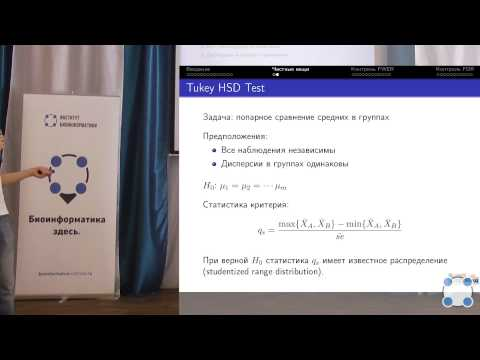

In [56]:
#  Институт биоинформатики "Проблема проверки множества статистических гипотез — Антон Коробейников", rus

from IPython.display import YouTubeVideo
YouTubeVideo('A2FgJP-OHWE', width=900, height=500)

Проверим те же гипотезы с уровнем значимости 0.003. Еще раз их озвучим:

Н0 - различия между экспериментальными группами, совершившими указанное событие, статистически не значимы

Н1 - различия между экспериментальными группами, совершившими указанное событие, статистически значимы

In [57]:
#посмотрим на события в 246 и 248 группах
ab_calc(exp, [246, 248], 0.003)

Tutorial
0.11191626409017713 0.10997240835632636
p-значение:  0.8264294010087645
Не получилось отвергнуть нулевую гипотезу по событию Tutorial: нет оснований считать доли разными
-------------------------------
 
MainScreenAppear
0.9863123993558777 0.9826566811194324
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу по событию MainScreenAppear: нет оснований считать доли разными
-------------------------------
 
OffersScreenAppear
0.6207729468599034 0.6034686637761135
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу по событию OffersScreenAppear: нет оснований считать доли разными
-------------------------------
 
CartScreenAppear
0.5096618357487923 0.48482459597950334
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу по событию CartScreenAppear: нет оснований считать доли разными
-------------------------------
 
PaymentScreenSuccessful
0.4830917874396135 0.46551044540796216
p-значение:  0.2122553275697796
Не п

Различия между экспериментальными группами 246 и 248, совершившими все события, статистически не значимы.

In [58]:
#посмотрим на события в 247 и 248 группах
ab_calc(exp, [247, 248], 0.003)

Tutorial
0.11261440509351373 0.10997240835632636
p-значение:  0.765323922474501
Не получилось отвергнуть нулевую гипотезу по событию Tutorial: нет оснований считать доли разными
-------------------------------
 
MainScreenAppear
0.9852765618782332 0.9826566811194324
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу по событию MainScreenAppear: нет оснований считать доли разными
-------------------------------
 
OffersScreenAppear
0.6048547552725826 0.6034686637761135
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу по событию OffersScreenAppear: нет оснований считать доли разными
-------------------------------
 
CartScreenAppear
0.4926382809391166 0.48482459597950334
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу по событию CartScreenAppear: нет оснований считать доли разными
-------------------------------
 
PaymentScreenSuccessful
0.46080382013529647 0.46551044540796216
p-значение:  0.7373415053803964
Не пол

Различия между экспериментальными группами 247 и 248, совершившими все события, статистически не значимы.

In [59]:
#посмотрим на события в объединенной контрольной группе и группе 248
ab_calc(exp_combined, [246, 248], 0.003)

Tutorial
0.11226736041624975 0.10997240835632636
p-значение:  0.764862472531507
Не получилось отвергнуть нулевую гипотезу по событию Tutorial: нет оснований считать доли разными
-------------------------------
 
MainScreenAppear
0.9857914748849309 0.9826566811194324
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу по событию MainScreenAppear: нет оснований считать доли разными
-------------------------------
 
OffersScreenAppear
0.6127676605963578 0.6034686637761135
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу по событию OffersScreenAppear: нет оснований считать доли разными
-------------------------------
 
CartScreenAppear
0.5011006603962378 0.48482459597950334
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу по событию CartScreenAppear: нет оснований считать доли разными
-------------------------------
 
PaymentScreenSuccessful
0.47188312987792674 0.46551044540796216
p-значение:  0.6004294282308704
Не 

Различия между объединенной контрольной группой (246-247) и экспериментальной группой 248, совершившими все события, статистически не значимы.

Все тесты превышают указанную поправку, соответсвенно нет оснований отвергнуть нулевую гипотезу.

### Вывод

С учетом полученных данных, можно сделать такой вывод:

Изменение шрифта не повлияло на метрики воронки.
Конверсии не различаются, все далеко за пределами стат значимости => шрифт можно менять или не менять, выручка от этого не изменится.
Возможно стоит провести уточняющий повторный эксперимент.